In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fakescorr import fakescorr, find_nearest
%matplotlib inline
from matplotlib import rc, rcParams
rcParams.update({'font.size':12})
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

def recovery(fakes, ID, save=False, figure=False):
    f = fakes.copy()
    f['ed_ratio']=f.ed_rec/f.ed_fake
    f = f.sort_values(by='ed_fake')[(f.ed_fake < 1e6) & (f.ed_ratio < 1.2)]
    
    lmax = np.log10(f.ed_fake.max())
    lmin = np.log10(f.ed_fake.min())
    bins = np.power(10,np.linspace(lmin,lmax,f.shape[0]/100))
    m = pd.DataFrame()
    f['range1'], bins = pd.cut(f.ed_fake, bins, retbins=True,include_lowest=True)
    m['mean_ed_fake'] = f.groupby('range1').ed_fake.mean()
    m['mean_rec_fake'] = f.groupby('range1').rec_fake.mean()
    m['std_rec_fake'] = f.groupby('range1').rec_fake.std()
    m = m.dropna(how='any')
    if figure == True:
        m.plot(x='mean_ed_fake', y='mean_rec_fake', yerr='std_rec_fake',loglog=True,
          label=('recovery rate'))
    threshold = m.mean_ed_fake[m.mean_rec_fake == find_nearest(m.mean_rec_fake.tolist(), 0.2)[0]].tolist()[0]
    return  threshold, m

def EDratio(fakes, ID, save=False, figure=False):
    f = fakes[fakes.rec_fake!=0.]
    f['ed_ratio']=f.ed_rec/f.ed_fake
    f = f.sort_values(by='ed_ratio')
    f = f[f.ed_ratio<1.5]
    if figure==True:
        plt.figure(figsize=(7,5))
        plt.scatter(f.ed_rec,f.ed_ratio,s=f.ed_rec_err/f.ed_rec*1e3, alpha=0.5,color='k',
                    label='$\sigma_{ED}/ED$')
        plt.axhline(y=1.,color='r')
        plt.axhline(y=1.1,color='r',linestyle='dashed')
        plt.xscale('log')
        plt.yscale('log')
        plt.ylim((0.1,1.5))
        plt.xlim((1,1e6))
        plt.xlabel('recovered ED (s)')
        plt.ylabel('recovered ratio of injected ED')
        plt.title('EPIC {}'.format(ID))
        plt.legend(loc=4, frameon=False)
    if save == True:
        plt.savefig('stars_shortlist/share/corrected/ed_ratio_{}.png'.format(ID),
                    dpi=300)
    return 



In [150]:
cluster = 'Pleiades'
test = 'run_06'
params = pd.read_csv('stars_shortlist/{0}/{0}_parameter.csv'.format(cluster))
oid_list = params.EPIC.tolist()

In [146]:
for ID in oid_list:
    try:
        path = 'stars_shortlist/{}/results/{}/fakes/{}_k2sc_allfakes.csv'.format(cluster,test,ID)
        df = pd.read_csv(path)
        threshold, m = recovery(df,ID)
        if 'thresh20p' not in params.columns:
            params['thresh20p'] = np.nan
        params['thresh20p'][params.EPIC==ID] = threshold
    except FileNotFoundError:
        pass

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


5.937039903752003 0.4946503206067482 14


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


5.557536649621271 0.18991807679023606 14
5.994834692996998 1.0409765570848615 13
5.997889996173966 0.9590899923544465 27
4.188041146095969 -1.0193034020936327 29
5.96918803098959 0.6485964349768988 13
5.973038232918719 1.0644968071053706 12
5.98906939593248 0.7454886179409451 14
5.990497131664915 1.0389553857753309 13
5.98569037011067 1.0573176609867057 12
5.964245976081225 1.0911600653919782 12
5.989873921393235 0.6388098041862619 28
5.99209361777561 1.4464944969595577 35
5.9838211442636355 1.1548985465982746 12
5.9227813086551215 0.7368625583075642 13
5.974971846761044 1.022955503760066 13
5.982082340653253 0.8393854762575153 14
5.9800829753651 1.0317041158802733 13
5.998924519133899 1.0862674159646002 13
5.9991648724611295 1.5402725514092335 11
5.168566889599662 -0.011988533195755206 14
5.9819394562694095 0.9109472481542956 27
5.996945639888898 0.7828323267251118 41
5.868308329547676 0.5489130183918689 14
5.999099331559725 1.4658905480357947 10
5.984080894286947 1.0355356097387316 1

8.039996797746333e+32 5.551029695858927e+34
5.005732510257815e+32 1.5851674185394183e+35
4.7857235099169524e+32 2.9347896654656185e+35
7.445815302449753e+32 7.614479912645633e+35


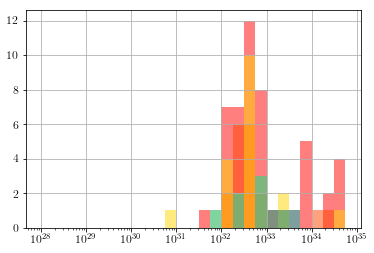

In [147]:
Tlims = [(3000.0,3249.0,'red'),(3250.0,3499.0,'orangered'),
         (3500.0,3749.0,'gold'),(3750.0,4000.0,'c'),(3000.0,7000.0,'black')]
for Tmin,Tmax,color in Tlims:
    Tb = params[(params['T'] <= Tmax) & (params['T'] >= Tmin)]
    Ethresh = Tb.thresh20p*Tb.L_quiet
    Ethresh.hist(bins=np.power(10,np.arange(28,35,0.25)),color=color,alpha=0.5)
    plt.xscale('log')
    print(Ethresh.median(),Ethresh.std())